<a href="https://colab.research.google.com/github/MYOUSSF/CreditRisk/blob/main/Probability_of_Default_Modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Credit Risk Modeling



## Data Preparation

Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

Import Data

In [ ]:
df_backup = pd.read_csv('/content/loan_data_2007_2014.csv')

<ipython-input-62-6fbe47fc8922>:1: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  df_backup = pd.read_csv('/content/loan_data_2007_2014.csv')


In [ ]:
df = df_backup.copy()

# Explore Data

In [ ]:
df.head(5)

,Unnamed: 0,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,0,1077501,1296599,5000,5000,4975.0,36 months,10.65,162.87,B,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1077430,1314167,2500,2500,2500.0,60 months,15.27,59.83,C,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,1077175,1313524,2400,2400,2400.0,36 months,15.96,84.33,C,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,1076863,1277178,10000,10000,10000.0,36 months,13.49,339.31,C,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,1075358,1311748,3000,3000,3000.0,60 months,12.69,67.79,B,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
def describe_dataset(df):
    variables = []
    dtypes = []
    count = []
    unique = []
    missing = []

    for item in df.columns:
        variables.append(item)
        dtypes.append(df[item].dtype)
        count.append(len(df[item]))
        unique.append(len(df[item].unique()))
        missing.append(df[item].isna().sum())

    output = pd.DataFrame({
        'variable': variables,
        'dtype': dtypes,
        'count': count,
        'unique': unique,
        'missing value': missing
    })

    return output

desc_data = describe_dataset(df)
desc_data

,variable,dtype,count,unique,missing value
0,Unnamed: 0,int64,466285,466285,0
1,id,int64,466285,466285,0
2,member_id,int64,466285,466285,0
3,loan_amnt,int64,466285,1352,0
4,funded_amnt,int64,466285,1354,0
...,...,...,...,...,...
70,all_util,float64,466285,1,466285
71,total_rev_hi_lim,float64,466285,14613,70276
72,inq_fi,float64,466285,1,466285
73,total_cu_tl,float64,466285,1,466285


Remove constant and ID columns

In [ ]:
irrelevant = desc_data[(desc_data['unique']==1) | (desc_data['unique']==len(df))]['variable'].to_list()
irrelevant

['Unnamed: 0',
 'id',
 'member_id',
 'url',
 'policy_code',
 'application_type',
 'annual_inc_joint',
 'dti_joint',
 'verification_status_joint',
 'open_acc_6m',
 'open_il_6m',
 'open_il_12m',
 'open_il_24m',
 'mths_since_rcnt_il',
 'total_bal_il',
 'il_util',
 'open_rv_12m',
 'open_rv_24m',
 'max_bal_bc',
 'all_util',
 'inq_fi',
 'total_cu_tl',
 'inq_last_12m']

In [ ]:
df.drop(columns=irrelevant, inplace=True)

## The target variable

In [ ]:
df['loan_status'].unique()

array(['Fully Paid', 'Charged Off', 'Current', 'Default',
       'Late (31-120 days)', 'In Grace Period', 'Late (16-30 days)',
       'Does not meet the credit policy. Status:Fully Paid',
       'Does not meet the credit policy. Status:Charged Off'],
      dtype=object)

In [ ]:
df['loan_status'].value_counts() / df['loan_status'].count()

,count
loan_status,
Current,0.480878
Fully Paid,0.396193
Charged Off,0.091092
Late (31-120 days),0.014798
In Grace Period,0.006747
Does not meet the credit policy. Status:Fully Paid,0.004263
Late (16-30 days),0.002612
Default,0.001784
Does not meet the credit policy. Status:Charged Off,0.001632


In [ ]:
# Replace the values in loan_status with 1 and 0
df['loan_status'] = \
np.where(df['loan_status'].\
         isin(['Charged Off', 'Default',
               'Does not meet the credit policy. Status:Charged Off',
               'Late (31-120 days)']), 1, 0)

# Rename the column from loan_status to default, where 1 is default and 0 is not
df.rename(columns={'loan_status': 'default'}, inplace=True)

# Preprocessing the Data

## Check the data types




In [ ]:
df.dtypes.unique()

array([dtype('int64'), dtype('float64'), dtype('O')], dtype=object)

In [ ]:
int_columns = df.select_dtypes("int64")
float_columns = df.select_dtypes("float64")
obj_columns = df.select_dtypes("O")

## Processing columns of type `int`




In [ ]:
int_columns.head(5)

,loan_amnt,funded_amnt,default,revol_bal
0,5000,5000,0,13648
1,2500,2500,1,1687
2,2400,2400,0,2956
3,10000,10000,0,5598
4,3000,3000,0,27783


We change the type of the amounts from int64 to float64.

In [ ]:
int_columns[['loan_amnt', 'funded_amnt', 'revol_bal']] =\
int_columns[['loan_amnt', 'funded_amnt', 'revol_bal']].astype('float64')

In [ ]:
int_columns.isnull().sum()

,0
loan_amnt,0
funded_amnt,0
default,0
revol_bal,0


## Processing columns of type `Object`




In [ ]:
obj_columns.head(5)

,term,grade,sub_grade,emp_title,emp_length,home_ownership,verification_status,issue_d,pymnt_plan,desc,purpose,title,zip_code,addr_state,earliest_cr_line,initial_list_status,last_pymnt_d,next_pymnt_d,last_credit_pull_d
0,36 months,B,B2,NaN,10+ years,RENT,Verified,Dec-11,n,Borrower added on 12/22/11 > I need to upgra...,credit_card,Computer,860xx,AZ,Jan-85,f,Jan-15,NaN,Jan-16
1,60 months,C,C4,Ryder,< 1 year,RENT,Source Verified,Dec-11,n,Borrower added on 12/22/11 > I plan to use t...,car,bike,309xx,GA,Apr-99,f,Apr-13,NaN,Sep-13
2,36 months,C,C5,NaN,10+ years,RENT,Not Verified,Dec-11,n,NaN,small_business,real estate business,606xx,IL,Nov-01,f,Jun-14,NaN,Jan-16
3,36 months,C,C1,AIR RESOURCES BOARD,10+ years,RENT,Source Verified,Dec-11,n,Borrower added on 12/21/11 > to pay for prop...,other,personel,917xx,CA,Feb-96,f,Jan-15,NaN,Jan-15
4,60 months,B,B5,University Medical Group,1 year,RENT,Source Verified,Dec-11,n,Borrower added on 12/21/11 > I plan on combi...,other,Personal,972xx,OR,Jan-96,f,Jan-16,Feb-16,Jan-16


In [ ]:
describe_dataset(obj_columns)

,variable,dtype,count,unique,missing value
0,term,object,466285,2,0
1,grade,object,466285,7,0
2,sub_grade,object,466285,35,0
3,emp_title,object,466285,205476,27588
4,emp_length,object,466285,12,21008
5,home_ownership,object,466285,6,0
6,verification_status,object,466285,3,0
7,issue_d,object,466285,91,0
8,pymnt_plan,object,466285,2,0
9,desc,object,466285,124436,340304


In [ ]:
obj_columns.loc[:, obj_columns.nunique() == 2].columns

Index(['term', 'pymnt_plan', 'initial_list_status'], dtype='object')

In [ ]:
# High cardinality features are collected in the list irrelevant
irrelevant = ['title', 'desc', 'emp_title', 'next_pymnt_d']
binary = ['term', 'pymnt_plan', 'initial_list_status']
dates = ['issue_d', 'earliest_cr_line', 'last_credit_pull_d', 'last_pymnt_d']
categorical = ['addr_state', 'zip_code', 'purpose',\
            'verification_status', 'home_ownership',\
            'sub_grade', 'grade']
numerical = ['emp_length']

### Drop irrelevant

In [ ]:
# Drop high cardinality features
obj_columns.drop(columns=irrelevant, inplace=True)

### Cast date columns into the correct format

In [ ]:
for date in dates:
    obj_columns[date] = pd.to_datetime(obj_columns[date], format='%b-%y', errors='coerce')

obj_columns[dates]

,issue_d,earliest_cr_line,last_credit_pull_d,last_pymnt_d
0,2011-12-01,1985-01-01,2016-01-01,2015-01-01
1,2011-12-01,1999-04-01,2013-09-01,2013-04-01
2,2011-12-01,2001-11-01,2016-01-01,2014-06-01
3,2011-12-01,1996-02-01,2015-01-01,2015-01-01
4,2011-12-01,1996-01-01,2016-01-01,2016-01-01
...,...,...,...,...
466280,2014-01-01,2003-04-01,2016-01-01,2016-01-01
466281,2014-01-01,1997-06-01,2016-01-01,2014-12-01
466282,2014-01-01,2001-12-01,2015-12-01,2016-01-01
466283,2014-01-01,2003-02-01,2015-04-01,2014-12-01


Check for missing values

In [ ]:
obj_columns[obj_columns[dates].isnull().any(axis=1)][dates]

,issue_d,earliest_cr_line,last_credit_pull_d,last_pymnt_d
26,2011-12-01,2003-10-01,2016-01-01,NaT
2731,2011-11-01,1997-11-01,2016-01-01,NaT
3625,2011-11-01,2006-06-01,2012-04-01,NaT
3998,2011-11-01,2008-08-01,2016-01-01,NaT
4220,2011-11-01,1998-10-01,2016-01-01,NaT
...,...,...,...,...
458391,2014-01-01,2003-06-01,2014-06-01,NaT
459366,2014-01-01,2004-02-01,2016-01-01,NaT
460654,2014-01-01,2067-04-01,NaT,2016-01-01
464853,2014-01-01,2001-01-01,2014-06-01,NaT


We'll replace the dates by their distance to a reference date.

In [ ]:
reference_date = pd.to_datetime('2017-12-01')
for date in dates:
    obj_columns[date] = reference_date - obj_columns[date]
    obj_columns[date] = obj_columns[date].dt.days.astype('float')

Rename the date columns

In [ ]:
obj_columns

,term,grade,sub_grade,emp_length,home_ownership,verification_status,issue_d,pymnt_plan,purpose,zip_code,addr_state,earliest_cr_line,initial_list_status,last_pymnt_d,last_credit_pull_d
0,36 months,B,B2,10+ years,RENT,Verified,2192.0,n,credit_card,860xx,AZ,12022.0,f,1065.0,700.0
1,60 months,C,C4,< 1 year,RENT,Source Verified,2192.0,n,car,309xx,GA,6819.0,f,1705.0,1552.0
2,36 months,C,C5,10+ years,RENT,Not Verified,2192.0,n,small_business,606xx,IL,5874.0,f,1279.0,700.0
3,36 months,C,C1,10+ years,RENT,Source Verified,2192.0,n,other,917xx,CA,7974.0,f,1065.0,1065.0
4,60 months,B,B5,1 year,RENT,Source Verified,2192.0,n,other,972xx,OR,8005.0,f,700.0,700.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
466280,60 months,C,C2,4 years,MORTGAGE,Source Verified,1430.0,n,debt_consolidation,773xx,TX,5358.0,w,700.0,700.0
466281,60 months,D,D5,10+ years,MORTGAGE,Verified,1430.0,n,debt_consolidation,377xx,TN,7488.0,f,1096.0,700.0
466282,60 months,D,D1,7 years,MORTGAGE,Verified,1430.0,n,debt_consolidation,458xx,OH,5844.0,f,700.0,731.0
466283,36 months,A,A4,3 years,OWN,Verified,1430.0,n,credit_card,913xx,CA,5417.0,w,1096.0,975.0


In [ ]:
new_cols = {'issue_d': 'Since_issue_d',
'earliest_cr_line': 'Since_earliest_cr_line',
'last_credit_pull_d': 'Since_last_credit_pull',
'last_pymnt_d': 'Since_last_pymnt'}

obj_columns = obj_columns.rename(columns=new_cols)

# New dates
dates = list(new_cols.values())
obj_columns[dates].head(5)

,Since_issue_d,Since_earliest_cr_line,Since_last_credit_pull,Since_last_pymnt
0,2192.0,12022.0,700.0,1065.0
1,2192.0,6819.0,1552.0,1705.0
2,2192.0,5874.0,700.0,1279.0
3,2192.0,7974.0,1065.0,1065.0
4,2192.0,8005.0,700.0,700.0


In [ ]:
obj_columns[dates].isnull().sum()

,0
Since_issue_d,0
Since_earliest_cr_line,29
Since_last_credit_pull,42
Since_last_pymnt,376


We'll fill missing values in `Since_earliest_cr_line` with 0, and leave the two other columns with missing values for later.

In [ ]:
obj_columns['Since_earliest_cr_line'].fillna(0, inplace=True)

### Numerical Values

In [ ]:
obj_columns['emp_length'].unique()

array(['10+ years', '< 1 year', '1 year', '3 years', '8 years', '9 years',
       '4 years', '5 years', '6 years', '2 years', '7 years', nan],
      dtype=object)

In [ ]:
obj_columns['emp_length'] = \
obj_columns['emp_length'].str.replace('+ years', '')
obj_columns['emp_length'] = \
obj_columns['emp_length'].str.replace('< 1 year', str(0))
obj_columns['emp_length'] = \
obj_columns['emp_length'].str.replace(' years', '')
obj_columns['emp_length'] = \
obj_columns['emp_length'].str.replace(' year', '')

Convert the strings to numeric

In [ ]:
obj_columns['emp_length'] = pd.to_numeric(obj_columns['emp_length'])

In [ ]:
obj_columns['emp_length']

,emp_length
0,10.0
1,0.0
2,10.0
3,10.0
4,1.0
...,...
466280,4.0
466281,10.0
466282,7.0
466283,3.0


Fill the missing values in the employment column with 0.

In [ ]:
obj_columns['emp_length'].fillna(0, inplace=True)

In [ ]:
obj_columns.isnull().sum()

,0
term,0
grade,0
sub_grade,0
emp_length,0
home_ownership,0
verification_status,0
Since_issue_d,0
pymnt_plan,0
purpose,0
zip_code,0


### Binary

In [ ]:
obj_columns['term'].unique()

array([' 36 months', ' 60 months'], dtype=object)

In [ ]:
obj_columns['pymnt_plan'].unique()

array(['n', 'y'], dtype=object)

In [ ]:
obj_columns['initial_list_status'].unique()

array(['f', 'w'], dtype=object)

In [ ]:
obj_columns['isThreeYearsTerm'] = obj_columns['term'].map({' 36 months': 1, ' 60 months': 0})
obj_columns['Payment_Plan'] = obj_columns['pymnt_plan'].map({'y': 1, 'n': 0})
obj_columns['Initial_Status'] = obj_columns['initial_list_status'].map({'w': 1, 'f': 0})
obj_columns.drop(columns=binary, inplace=True)

### Categorical

In [ ]:
categorical

['addr_state',
 'zip_code',
 'purpose',
 'verification_status',
 'home_ownership',
 'sub_grade',
 'grade']

In [ ]:
describe_dataset(obj_columns[categorical])

,variable,dtype,count,unique,missing value
0,addr_state,object,466285,50,0
1,zip_code,object,466285,888,0
2,purpose,object,466285,14,0
3,verification_status,object,466285,3,0
4,home_ownership,object,466285,6,0
5,sub_grade,object,466285,35,0
6,grade,object,466285,7,0


## Processing columns of type `float`




In [ ]:
float_columns.columns.values

array(['funded_amnt_inv', 'int_rate', 'installment', 'annual_inc', 'dti',
       'delinq_2yrs', 'inq_last_6mths', 'mths_since_last_delinq',
       'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_util',
       'total_acc', 'out_prncp', 'out_prncp_inv', 'total_pymnt',
       'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
       'last_pymnt_amnt', 'collections_12_mths_ex_med',
       'mths_since_last_major_derog', 'acc_now_delinq', 'tot_coll_amt',
       'tot_cur_bal', 'total_rev_hi_lim'], dtype=object)

In [ ]:
float_columns.head(5)

,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,...,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,collections_12_mths_ex_med,mths_since_last_major_derog,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim
0,4975.0,10.65,162.87,24000.0,27.65,0.0,1.0,NaN,NaN,3.0,...,0.00,0.00,0.00,171.62,0.0,NaN,0.0,NaN,NaN,NaN
1,2500.0,15.27,59.83,30000.0,1.00,0.0,5.0,NaN,NaN,3.0,...,0.00,117.08,1.11,119.66,0.0,NaN,0.0,NaN,NaN,NaN
2,2400.0,15.96,84.33,12252.0,8.72,0.0,2.0,NaN,NaN,2.0,...,0.00,0.00,0.00,649.91,0.0,NaN,0.0,NaN,NaN,NaN
3,10000.0,13.49,339.31,49200.0,20.00,0.0,1.0,35.0,NaN,10.0,...,16.97,0.00,0.00,357.48,0.0,NaN,0.0,NaN,NaN,NaN
4,3000.0,12.69,67.79,80000.0,17.94,0.0,0.0,38.0,NaN,15.0,...,0.00,0.00,0.00,67.79,0.0,NaN,0.0,NaN,NaN,NaN


In [ ]:
describe_dataset(float_columns)

,variable,dtype,count,unique,missing value
0,funded_amnt_inv,float64,466285,9854,0
1,int_rate,float64,466285,506,0
2,installment,float64,466285,55622,0
3,annual_inc,float64,466285,31902,4
4,dti,float64,466285,3997,0
5,delinq_2yrs,float64,466285,25,29
6,inq_last_6mths,float64,466285,29,29
7,mths_since_last_delinq,float64,466285,146,250351
8,mths_since_last_record,float64,466285,124,403647
9,open_acc,float64,466285,63,29


### Deal with missing values

All the columns with missing values

In [ ]:
float_columns.isnull().sum()[float_columns.isnull().sum()>0]

,0
annual_inc,4
delinq_2yrs,29
inq_last_6mths,29
mths_since_last_delinq,250351
mths_since_last_record,403647
open_acc,29
pub_rec,29
revol_util,340
total_acc,29
collections_12_mths_ex_med,145


The columns `mths_since_last_delinq`, `mths_since_last_record`, and `mths_since_last_major_derog` represent the time since the last delinquency. We assume that clients with missing values have never committed a delinquency. Ideally, the values in these columns should be as large as possible. Therefore, instead of filling the missing values with `inf`, we first invert the values in these columns and then fill the missing values with 0.

In [ ]:
cols_to_inverse = ['mths_since_last_delinq',\
                   'mths_since_last_record',\
                   'mths_since_last_major_derog']

Before we invert the columns let's search for the records that are originally 0. We should replace these by NaN

In [ ]:
float_columns[cols_to_inverse][(float_columns['mths_since_last_delinq']==0) | (float_columns['mths_since_last_record']==0) | (float_columns['mths_since_last_major_derog']==0)]

,mths_since_last_delinq,mths_since_last_record,mths_since_last_major_derog
35075,0.0,0.0,NaN
35127,13.0,0.0,NaN
35431,0.0,0.0,NaN
38512,46.0,0.0,NaN
38786,0.0,0.0,NaN
...,...,...,...
458439,0.0,NaN,NaN
458470,0.0,NaN,0.0
459806,0.0,NaN,25.0
460958,0.0,NaN,0.0


In [ ]:
for col in cols_to_inverse:
    float_columns[col].replace(0, np.nan, inplace=True)

float_columns[cols_to_inverse][(float_columns['mths_since_last_delinq']==0) | (float_columns['mths_since_last_record']==0) | (float_columns['mths_since_last_major_derog']==0)]

,mths_since_last_delinq,mths_since_last_record,mths_since_last_major_derog


In [ ]:
for col in cols_to_inverse:
    float_columns[col] = 1 / float_columns[col]
    float_columns[col].fillna(0, inplace=True)

In [ ]:
float_columns['total_rev_hi_lim'].fillna(0, inplace=True)
float_columns['tot_coll_amt'].fillna(0, inplace=True)
float_columns['acc_now_delinq'].fillna(0, inplace=True)
float_columns['total_acc'].fillna(0, inplace=True)
float_columns['pub_rec'].fillna(0, inplace=True)
float_columns['open_acc'].fillna(0, inplace=True)
float_columns['inq_last_6mths'].fillna(0, inplace=True)
float_columns['delinq_2yrs'].fillna(0, inplace=True)
float_columns['collections_12_mths_ex_med'].fillna(0, inplace=True)
float_columns['tot_cur_bal'].fillna(0, inplace=True)
float_columns['revol_util'].fillna(0, inplace=True)

In [ ]:
float_columns.isnull().sum()[float_columns.isnull().sum()>0]

,0
annual_inc,4


We fill the missing annual income with the mean income of the state. We first concatenate the dataframes.

In [ ]:
new_df = pd.concat([int_columns, float_columns, obj_columns], axis=1)

# Calculate mean income by state
mean_income_by_state = new_df.groupby('addr_state')['annual_inc'].mean()

# Define a function to fill NaN values with the state mean
def fill_na_with_state_mean(row):
    if pd.isna(row['annual_inc']):
        return mean_income_by_state[row['addr_state']]
    return row['annual_inc']

# Apply the function to fill NaN values in the 'annual_inc' column
new_df['annual_inc'] = new_df.apply(fill_na_with_state_mean, axis=1)

In [ ]:
new_df.head(5)

,loan_amnt,funded_amnt,default,revol_bal,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,...,Since_issue_d,purpose,zip_code,addr_state,Since_earliest_cr_line,Since_last_pymnt,Since_last_credit_pull,isThreeYearsTerm,Payment_Plan,Initial_Status
0,5000.0,5000.0,0,13648.0,4975.0,10.65,162.87,24000.0,27.65,0.0,...,2192.0,credit_card,860xx,AZ,12022.0,1065.0,700.0,1,0,0
1,2500.0,2500.0,1,1687.0,2500.0,15.27,59.83,30000.0,1.00,0.0,...,2192.0,car,309xx,GA,6819.0,1705.0,1552.0,0,0,0
2,2400.0,2400.0,0,2956.0,2400.0,15.96,84.33,12252.0,8.72,0.0,...,2192.0,small_business,606xx,IL,5874.0,1279.0,700.0,1,0,0
3,10000.0,10000.0,0,5598.0,10000.0,13.49,339.31,49200.0,20.00,0.0,...,2192.0,other,917xx,CA,7974.0,1065.0,1065.0,1,0,0
4,3000.0,3000.0,0,27783.0,3000.0,12.69,67.79,80000.0,17.94,0.0,...,2192.0,other,972xx,OR,8005.0,700.0,700.0,0,0,0


We return to the missing values we left above.

In [ ]:
new_df.isnull().sum()[new_df.isnull().sum()>0]

,0
Since_last_pymnt,376
Since_last_credit_pull,42


Since there aren't many missing values, and for simplicity, we'll just drop the remaining missing values.

In [ ]:
new_df.dropna(inplace=True)

In [ ]:
new_df.to_csv('cleaned_loan_data_2007-2014.csv', index=False)
new_df[new_df['default']==1].to_csv('cleaned_loan_data_2007-2014_defaults.csv', index=False)

# Load Cleaned Data

In [39]:
df = pd.read_csv('/content/cleaned_loan_data_2007-2014.csv')
df.head(5)

,loan_amnt,funded_amnt,default,revol_bal,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,...,Since_issue_d,purpose,zip_code,addr_state,Since_earliest_cr_line,Since_last_pymnt,Since_last_credit_pull,isThreeYearsTerm,Payment_Plan,Initial_Status
0,5000.0,5000.0,0,13648.0,4975.0,10.65,162.87,24000.0,27.65,0.0,...,2192.0,credit_card,860xx,AZ,12022.0,1065.0,700.0,1,0,0
1,2500.0,2500.0,1,1687.0,2500.0,15.27,59.83,30000.0,1.00,0.0,...,2192.0,car,309xx,GA,6819.0,1705.0,1552.0,0,0,0
2,2400.0,2400.0,0,2956.0,2400.0,15.96,84.33,12252.0,8.72,0.0,...,2192.0,small_business,606xx,IL,5874.0,1279.0,700.0,1,0,0
3,10000.0,10000.0,0,5598.0,10000.0,13.49,339.31,49200.0,20.00,0.0,...,2192.0,other,917xx,CA,7974.0,1065.0,1065.0,1,0,0
4,3000.0,3000.0,0,27783.0,3000.0,12.69,67.79,80000.0,17.94,0.0,...,2192.0,other,972xx,OR,8005.0,700.0,700.0,0,0,0


In [40]:
df.columns.values

array(['loan_amnt', 'funded_amnt', 'default', 'revol_bal',
       'funded_amnt_inv', 'int_rate', 'installment', 'annual_inc', 'dti',
       'delinq_2yrs', 'inq_last_6mths', 'mths_since_last_delinq',
       'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_util',
       'total_acc', 'out_prncp', 'out_prncp_inv', 'total_pymnt',
       'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
       'last_pymnt_amnt', 'collections_12_mths_ex_med',
       'mths_since_last_major_derog', 'acc_now_delinq', 'tot_coll_amt',
       'tot_cur_bal', 'total_rev_hi_lim', 'grade', 'sub_grade',
       'emp_length', 'home_ownership', 'verification_status',
       'Since_issue_d', 'purpose', 'zip_code', 'addr_state',
       'Since_earliest_cr_line', 'Since_last_pymnt',
       'Since_last_credit_pull', 'isThreeYearsTerm', 'Payment_Plan',
       'Initial_Status'], dtype=object)

## Check for Outliers

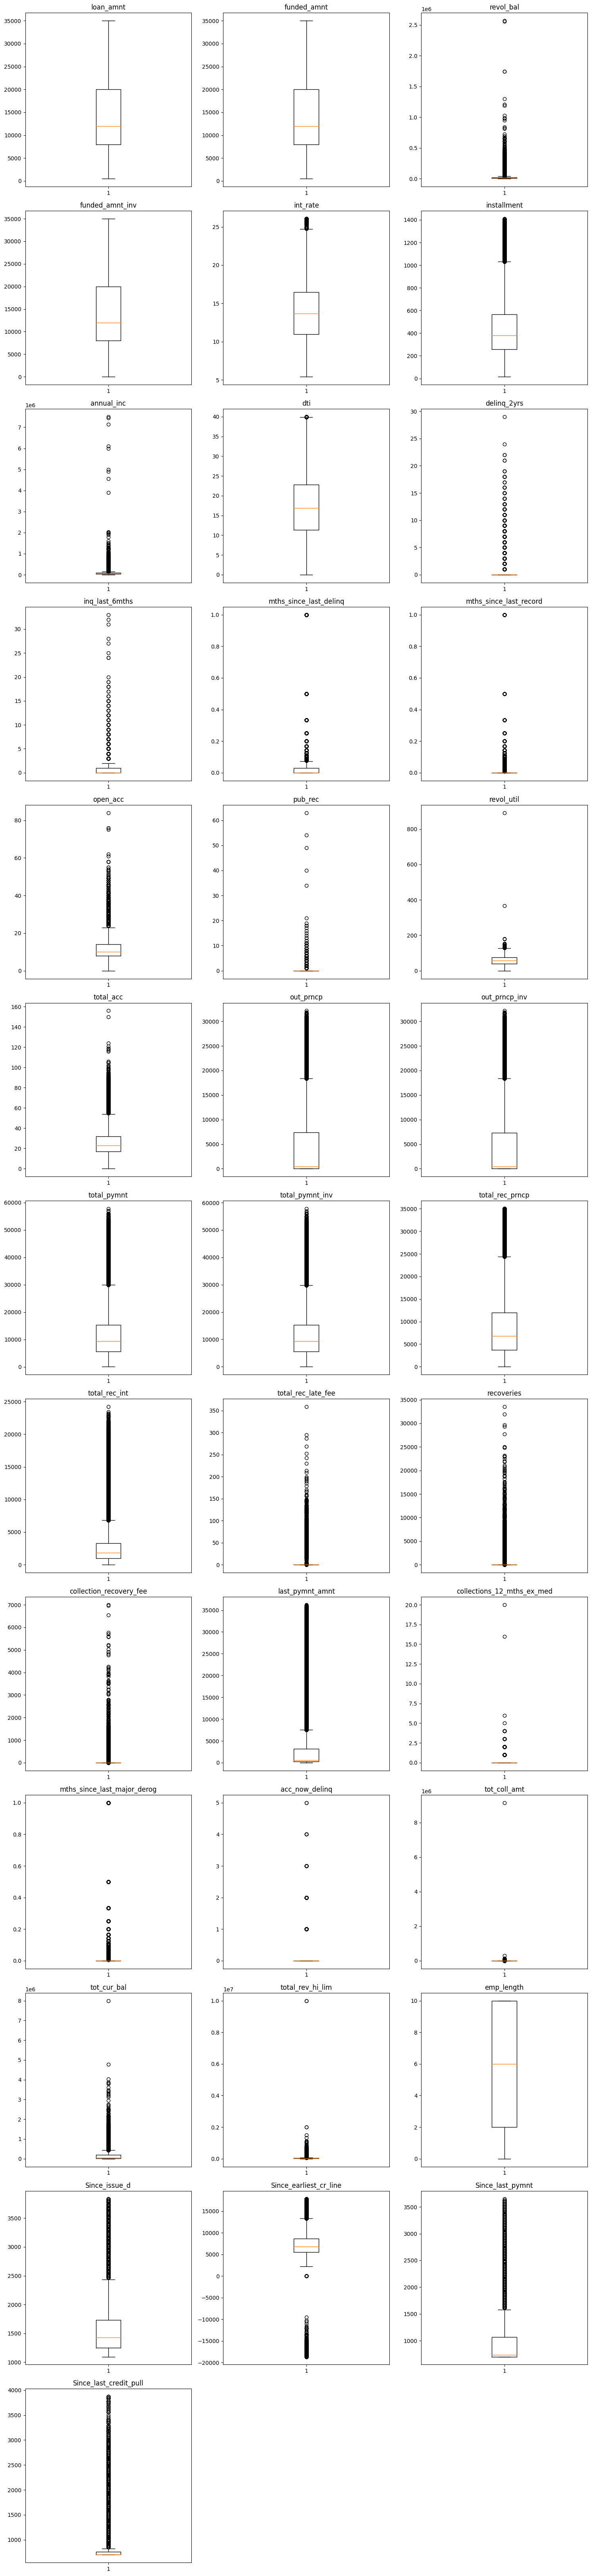

In [41]:
def plot_boxplot(df, columns_per_row=3):
    num_plots = len(df.columns)
    num_rows = (num_plots + columns_per_row - 1) // columns_per_row

    fig, axes = plt.subplots(nrows=num_rows, ncols=columns_per_row, figsize=(15, 5 * num_rows))
    axes = axes.flatten()

    for i, column in enumerate(df.columns):
        axes[i].boxplot(df[column])
        axes[i].set_title(f'{column}')

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

numerical = df.select_dtypes('float')
plot_boxplot(numerical, columns_per_row=3)

In [42]:
cols_with_potential_outliers = ['revol_bal', 'revol_util', 'tot_coll_amt', 'total_rev_hi_lim', 'Since_earliest_cr_line']

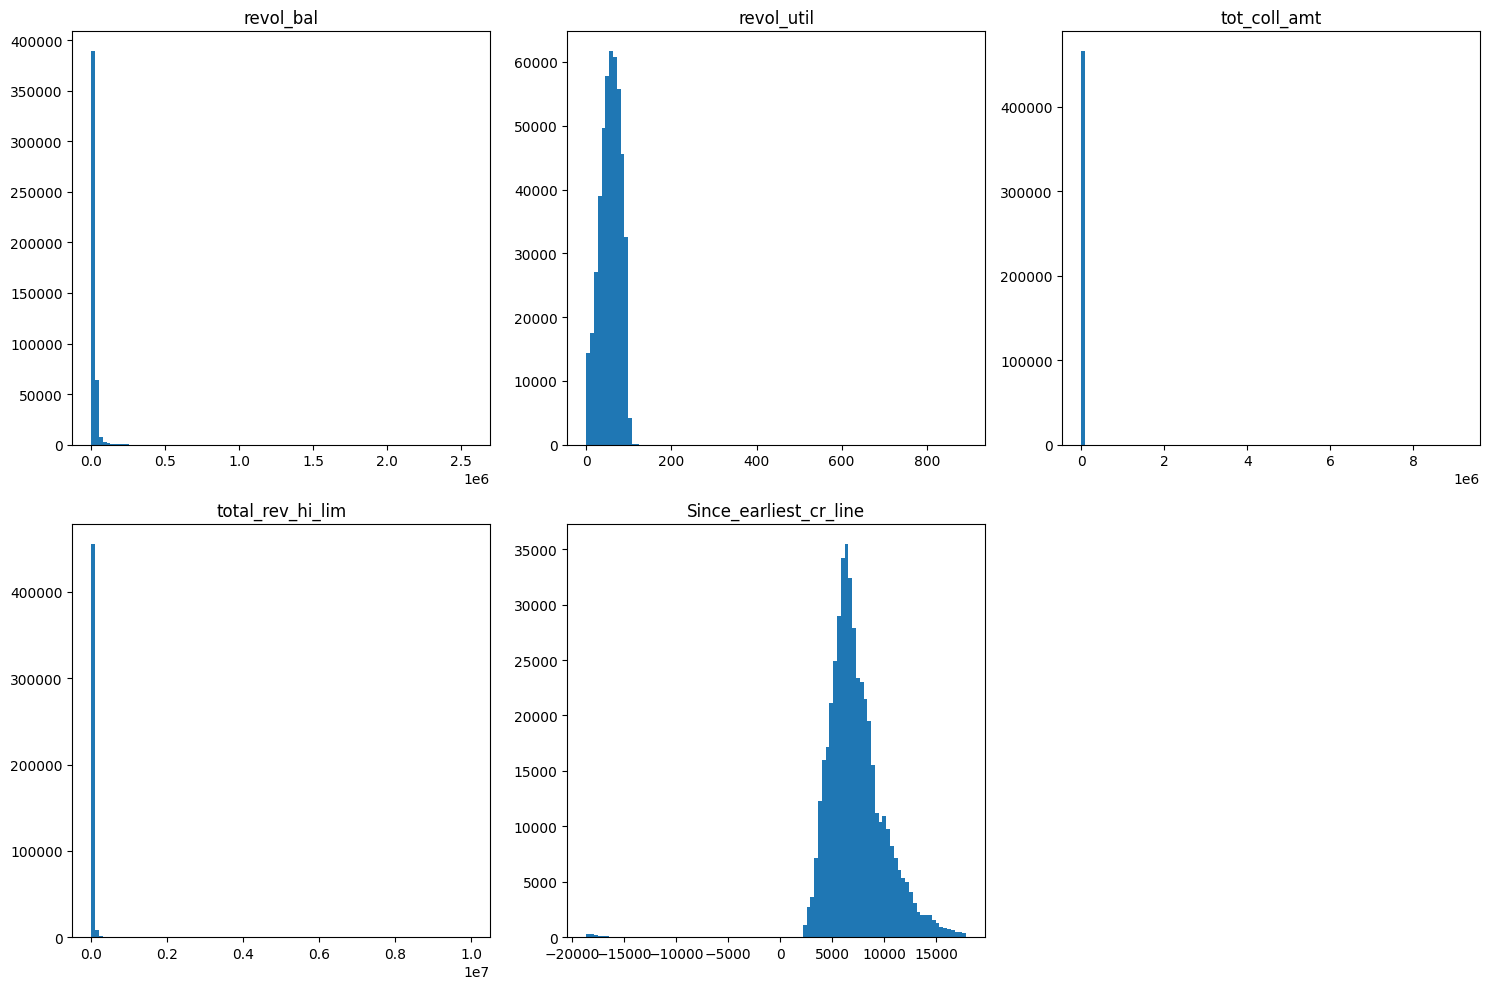

In [43]:
def plot_dist(df, columns_per_row=3):
    num_plots = len(df.columns)
    num_rows = (num_plots + columns_per_row - 1) // columns_per_row

    fig, axes = plt.subplots(nrows=num_rows, ncols=columns_per_row, figsize=(15, 5 * num_rows))
    axes = axes.flatten()

    for i, column in enumerate(df.columns):
        axes[i].hist(df[column], bins=100)
        axes[i].set_title(f'{column}')

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

numerical = df.select_dtypes('float')
plot_dist(df[cols_with_potential_outliers], columns_per_row=3)

In [44]:
df['Since_earliest_cr_line'] = df['Since_earliest_cr_line'].clip(lower=0)

In [45]:
df[df['revol_bal']>500000].shape

(41, 48)

In [46]:
df[df['revol_util']>160].shape

(4, 48)

In [47]:
df[df['tot_coll_amt']>50000].shape

(55, 48)

In [48]:
df[df['total_rev_hi_lim']>500000].shape

(74, 48)

In [49]:
x1 = df['revol_bal']<=500000
x2 = df['revol_util']<=200
# x3 = df['tot_coll_amt']<=50000
x4 = df['total_rev_hi_lim']<=500000

df = df[x1 & x2 & x4]

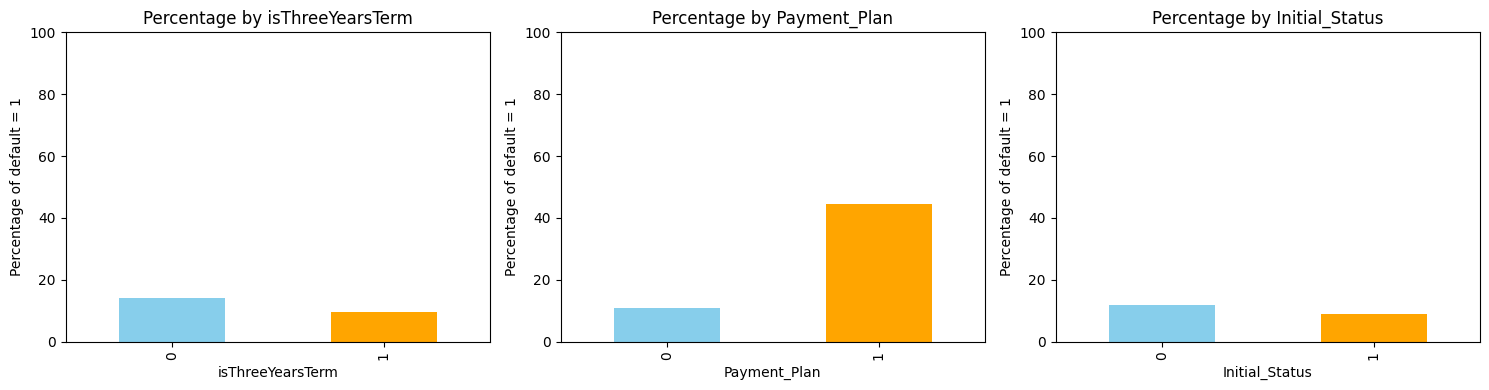

In [50]:
def plot_binary_percentages(df, binary_cols, target, n_cols=2):
    n_rows = (len(binary_cols) + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
    axes = axes.flatten()

    for i, col in enumerate(binary_cols):
        percentages = df.groupby(col)[target].mean() * 100

        percentages.plot(kind='bar', ax=axes[i], color=['skyblue', 'orange'])
        axes[i].set_title(f'Percentage by {col}')
        axes[i].set_xlabel(col)
        axes[i].set_ylim(0, 100)
        axes[i].set_ylabel(f'Percentage of {target} = 1')

    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

binary_cols = ['isThreeYearsTerm', 'Payment_Plan', 'Initial_Status']
plot_binary_percentages(df, binary_cols, target='default', n_cols=3)

# Categorical Encoding

In [51]:
categorical = df.select_dtypes('O').columns.values
categorical

array(['grade', 'sub_grade', 'home_ownership', 'verification_status',
       'purpose', 'zip_code', 'addr_state'], dtype=object)

Function for discrete variables: calculate 'weight of eveidence' and 'information value'

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


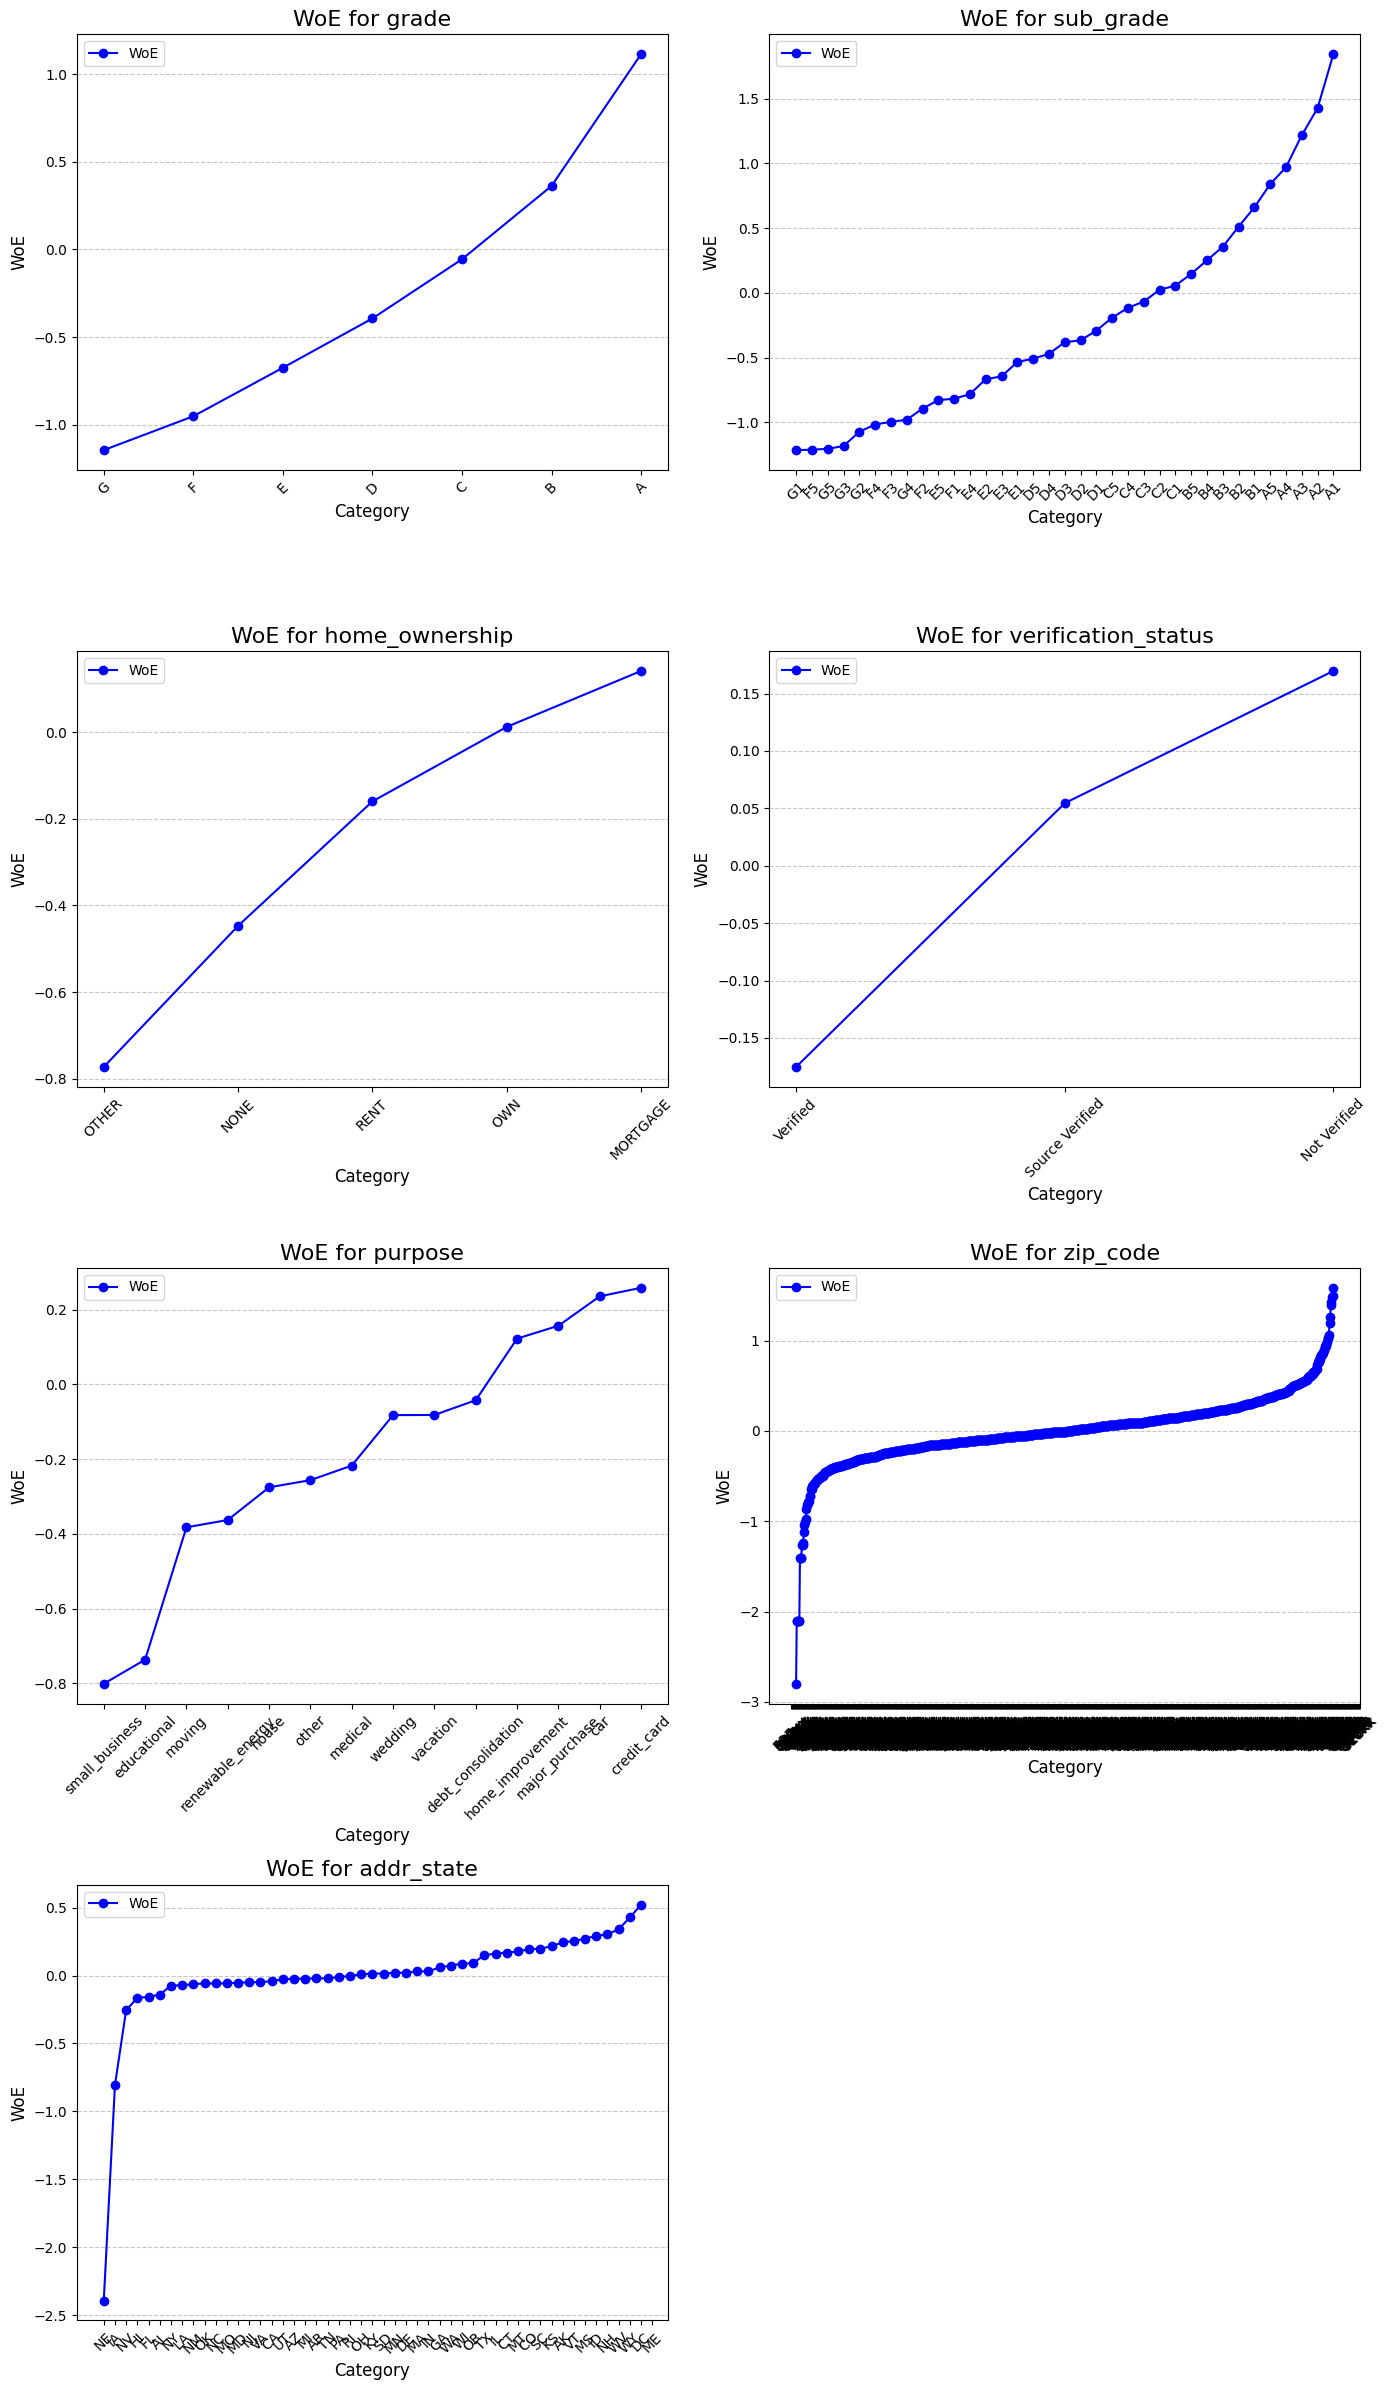

In [52]:
def compute_woe(feature, target):
    feature_target_df = pd.crosstab(feature, target, normalize='columns')

    # Get the proportions of good (target == 0) and bad (target == 1) outcomes
    feature_target_df['good_dist'] = feature_target_df[0]
    feature_target_df['bad_dist'] = feature_target_df[1]

    # Compute WoE for each category
    feature_target_df['WoE'] = np.log(feature_target_df['good_dist'] / feature_target_df['bad_dist'])

    return feature_target_df[['good_dist', 'bad_dist', 'WoE']]

def plot_woe(features, df, target, n_cols=2):
    n_features = len(features)
    n_rows = (n_features + 1) // n_cols

    # Create a figure with subplots in 2 columns
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(14, 6 * n_rows))
    axs = axs.flatten()  # Flatten to 1D to iterate easily

    for i, feature in enumerate(features):
        # Compute WoE for the current feature
        woe_df = compute_woe(df[feature], df[target])

        # Sort the WoE values to ensure an increasing line plot
        woe_df_sorted = woe_df.sort_values(by='WoE')

        # Plot WoE as a line plot for the feature
        axs[i].plot(woe_df_sorted.index, woe_df_sorted['WoE'], marker='o', linestyle='-', color='blue', label='WoE')
        axs[i].set_title(f'WoE for {feature}', fontsize=16)
        axs[i].set_xlabel('Category', fontsize=12)
        axs[i].set_ylabel('WoE', fontsize=12)
        axs[i].tick_params(axis='x', rotation=45)
        axs[i].grid(True, axis='y', linestyle='--', alpha=0.7)
        axs[i].legend()

    for j in range(i + 1, len(axs)):
        fig.delaxes(axs[j])

    # Adjust layout for better readability
    plt.tight_layout()
    plt.show()

plot_woe(categorical, df, 'default', n_cols=2)

In [53]:
df[['sub_grade', 'default']].groupby('sub_grade')['default'].mean()

,default
sub_grade,
A1,0.018902
A2,0.028415
A3,0.034804
A4,0.044134
A5,0.049998
B1,0.059202
B2,0.068128
B3,0.078652
B4,0.086579


In [54]:
# Check if each sub_grade corresponds to only one grade
mapping = df.groupby('sub_grade')['grade'].nunique()

# If all values are 1, grade is perfectly predictable from sub_grade
if (mapping == 1).all():
    print("Grade is perfectly predictable from sub_grade and may be redundant.")
else:
    print("Grade contains additional information.")

Grade is perfectly predictable from sub_grade and may be redundant.


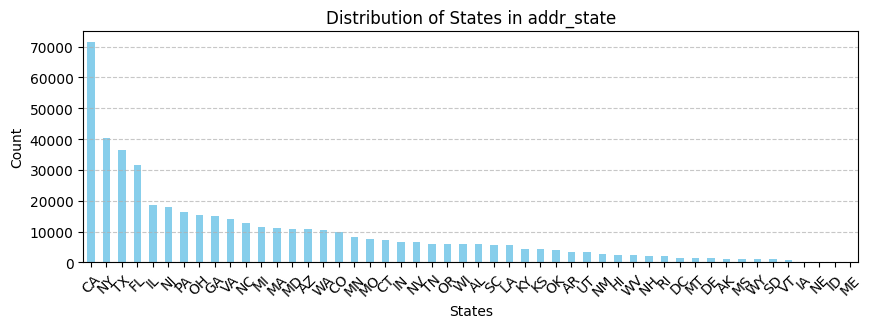

In [55]:
state_counts = df['addr_state'].value_counts()
# state_counts = state_counts[state_counts<2000]

# Plotting the distribution
plt.figure(figsize=(10, 3))
state_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution of States in addr_state')
plt.xlabel('States')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Verify whether high or low WoE values are influenced by the representation of states in the dataset

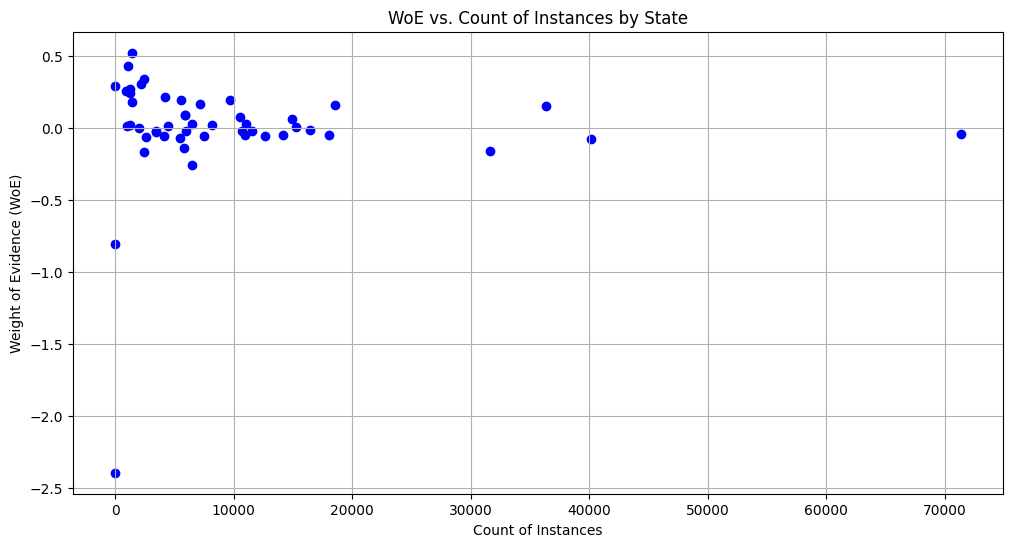

In [56]:
woe_by_state = compute_woe(df['addr_state'], df['default'])
# Count instances per state
state_counts = df['addr_state'].value_counts().reset_index()
state_counts.columns = ['addr_state', 'count']

# Merge counts with WoE
woe_counts = woe_by_state.merge(state_counts, on='addr_state', how='left')

# Replace infinite values with NaN
woe_counts.replace([np.inf, -np.inf], np.nan, inplace=True)

# Drop rows with NaN values in the WoE column
woe_counts.dropna(subset=['WoE'], inplace=True)


plt.figure(figsize=(12, 6))
plt.scatter(woe_counts['count'], woe_counts['WoE'], color='blue')
plt.title('WoE vs. Count of Instances by State')
plt.xlabel('Count of Instances')
plt.ylabel('Weight of Evidence (WoE)')
plt.grid()
plt.show()

In [57]:
df[['addr_state', 'default']].groupby('addr_state')['default'].mean().sort_values(ascending=False)

,default
addr_state,
NE,0.571429
IA,0.214286
NV,0.135679
HI,0.125604
FL,0.124664
AL,0.122927
NY,0.115969
LA,0.115630
NM,0.114849


We'll remove the outlier states: ME, NE, ID and IA.

In [58]:
states_to_remove = ['ME', 'NE', 'ID', 'IA']
df = df[~df['addr_state'].isin(states_to_remove)]

We will drop zip_code, grade and recoveries columns. For zip_code, the column has high cardinality, is sensitive to population representation, and already addr_state provides and aggregate for it. The variable grade is redundant since sub_grade is a refinement of grade.

In [59]:
df.drop(columns=['grade', 'zip_code'], inplace=True)

# Association Between Numerical Variables and the Target: Potential Data Leakage

In [60]:
from scipy.stats import pointbiserialr

results = []

for col in df.select_dtypes('float').columns:
    r_pb, p_value = pointbiserialr(df['default'], df[col])
    results.append({'Variable': col, 'r_pb': r_pb, 'p_value': p_value})

biserials = pd.DataFrame(results)
biserials.head(5)

,Variable,r_pb,p_value
0,loan_amnt,0.012762,3.051935e-18
1,funded_amnt,0.011936,3.760276e-16
2,revol_bal,-0.020177,3.804733e-43
3,funded_amnt_inv,0.008272,1.649183e-08
4,int_rate,0.171703,0.000000e+00


In [61]:
biserials[biserials['r_pb'].abs()>0.1]

,Variable,r_pb,p_value
4,int_rate,0.171703,0.0
16,out_prncp,-0.157638,0.0
17,out_prncp_inv,-0.157624,0.0
18,total_pymnt,-0.192277,0.0
19,total_pymnt_inv,-0.193011,0.0
20,total_rec_prncp,-0.251975,0.0
22,total_rec_late_fee,0.148571,0.0
23,recoveries,0.441036,0.0
24,collection_recovery_fee,0.300419,0.0
25,last_pymnt_amnt,-0.167306,0.0


In [62]:
from scipy.stats import ks_2samp

results = []

for col in df.select_dtypes('float').columns:
    ks_stat, p_value = ks_2samp(df['default'], df[col])
    results.append({'Variable': col, 'KS': ks_stat, 'p_value': p_value})

KS_scores = pd.DataFrame(results)
KS_scores.sort_values(by=['KS'],ascending=False).iloc[:20]

,Variable,KS,p_value
0,loan_amnt,1.000000,0.0
6,annual_inc,1.000000,0.0
35,Since_last_pymnt,1.000000,0.0
33,Since_issue_d,1.000000,0.0
1,funded_amnt,1.000000,0.0
18,total_pymnt,1.000000,0.0
5,installment,1.000000,0.0
4,int_rate,1.000000,0.0
36,Since_last_credit_pull,1.000000,0.0
21,total_rec_int,0.999991,0.0


<ipython-input-63-71b2e1cf8b31>:7: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(df[df[target] == 0][feature], label='Class 0', fill=True, color='blue')
<ipython-input-63-71b2e1cf8b31>:7: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(df[df[target] == 0][feature], label='Class 0', fill=True, color='blue')


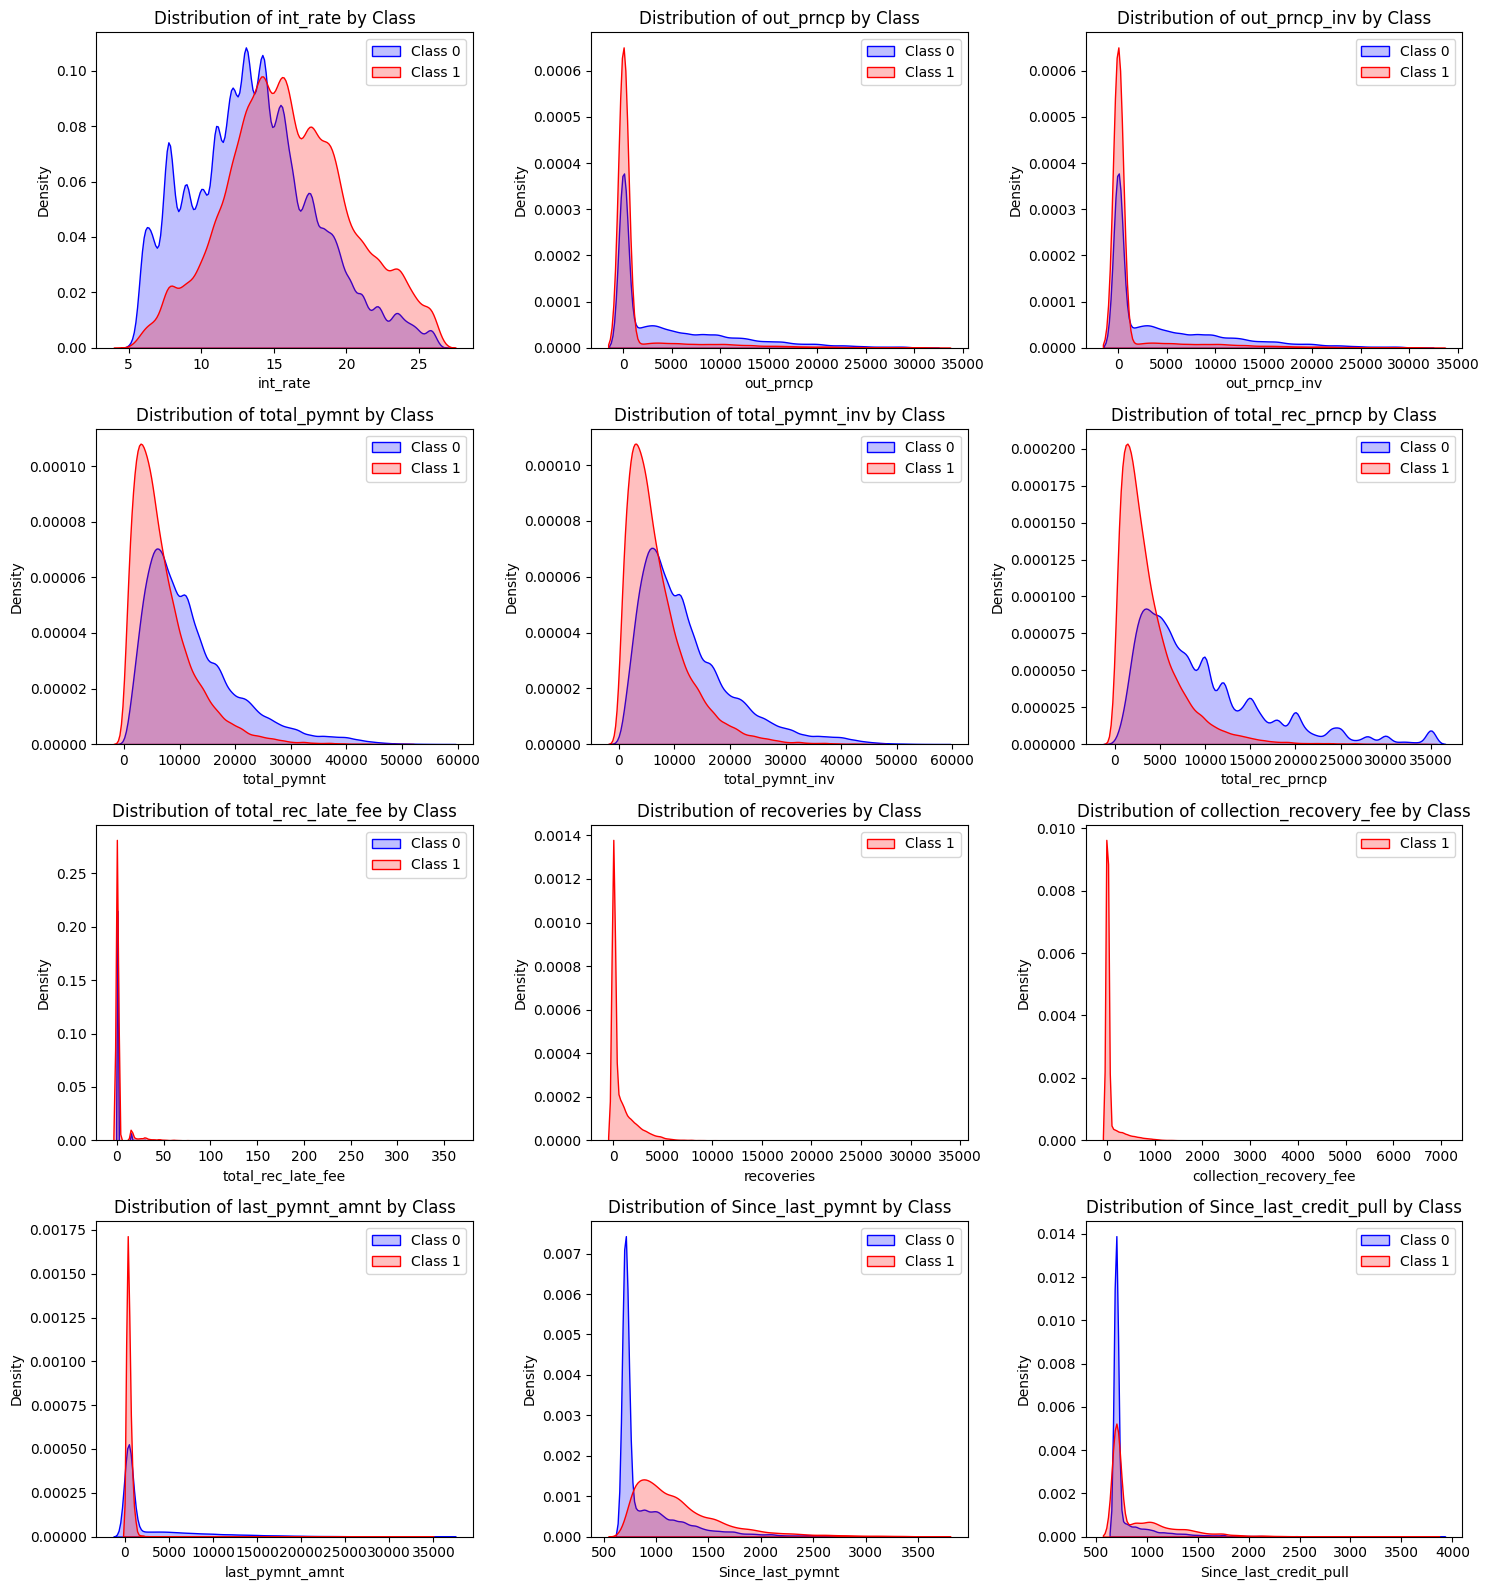

In [63]:
def plot_class_distributions(df, features, target, n_cols=2):
    n_rows = (len(features) + n_cols - 1) // n_cols
    plt.figure(figsize=(5 * n_cols, 4 * n_rows))

    for i, feature in enumerate(features):
        plt.subplot(n_rows, n_cols, i + 1)
        sns.kdeplot(df[df[target] == 0][feature], label='Class 0', fill=True, color='blue')
        sns.kdeplot(df[df[target] == 1][feature], label='Class 1', fill=True, color='red')

        plt.title(f'Distribution of {feature} by Class')
        plt.xlabel(feature)
        plt.ylabel('Density')
        plt.legend()

    plt.tight_layout()
    plt.show()


potential_leaky_cols = biserials[biserials['r_pb'].abs()>0.1]['Variable'].values
plot_class_distributions(df, potential_leaky_cols, 'default', n_cols=3)

In [64]:
# def compute_importance(df, feature, target, bins=100):
#     pos = df[df[target] == 1][feature].to_numpy()
#     neg = df[df[target] == 0][feature].to_numpy()

#     pos_min, pos_max = pos.min(), pos.max()
#     neg_min, neg_max = neg.min(), neg.max()

#     min_val = min(pos_min, neg_min)
#     max_val = max(pos_max, neg_max)

#     pos_dist, _ = np.histogram(pos, bins=bins, range=(min_val, max_val), density=True)
#     neg_dist, _ = np.histogram(neg, bins=bins, range=(min_val, max_val), density=True)
#     diff = np.sqrt(np.sum((pos_dist - neg_dist)**2))
#     return pos_dist, neg_dist, diff

We can confidently say we found the leaky variables:

In [65]:
leaky_cols = ['collection_recovery_fee', 'recoveries']
df.drop(columns=leaky_cols, inplace=True)

Finally we can fit out data to a model. We use xgboost

In [66]:
categorical = df.select_dtypes('O').columns.values

In [68]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Separate features and target variable
X = df.copy()
y = X['default']               # Target variable
X = X.drop('default', axis=1)  # Features


# Convert categorical columns to 'category' dtype
for col in categorical:
    X[col] = X[col].astype('category')

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# Create and train the XGBoost model with categorical handling
model = xgb.XGBClassifier(use_label_encoder=False,
            eval_metric='logloss',
            scale_pos_weight=(y_train.value_counts()[1] / y_train.value_counts()[0]),
            enable_categorical=True)

model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print(classification_report(y_test, y_pred))

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [03:49:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 1.00
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     83035
           1       1.00      0.96      0.98     10114

    accuracy                           1.00     93149
   macro avg       1.00      0.98      0.99     93149
weighted avg       1.00      1.00      1.00     93149



ROC AUC Score: 1.00


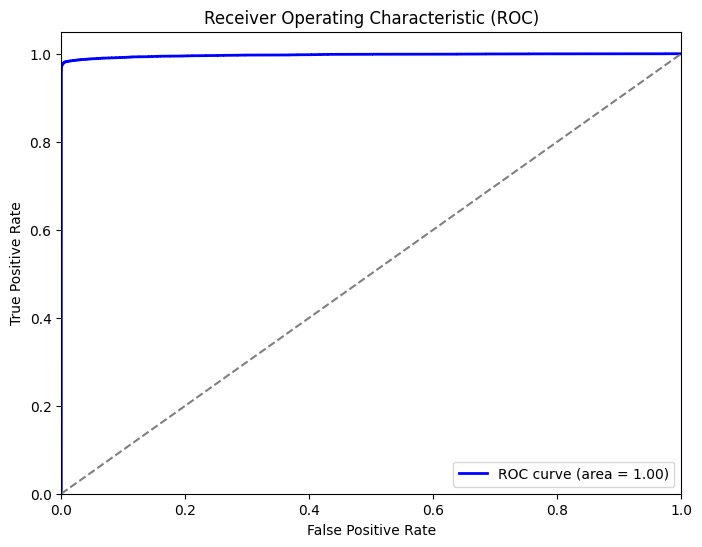

In [69]:
from sklearn.metrics import roc_auc_score, roc_curve, auc

# Predict probabilities for the positive class
y_pred_prob = model.predict_proba(X_test)[:, 1]

# Compute ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred_prob)
print(f"ROC AUC Score: {roc_auc:.2f}")

# Plot the ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc_value = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc_value:.2f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

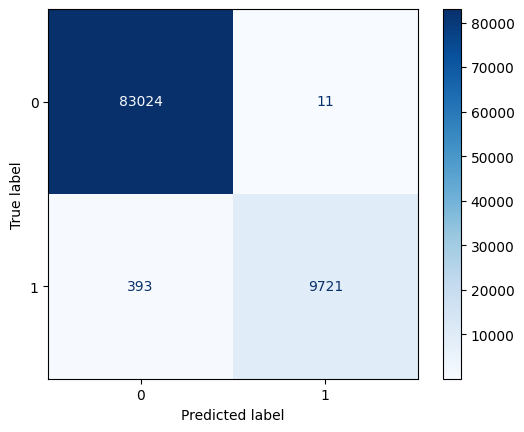

In [70]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap='Blues')
plt.show()

# Feature importance

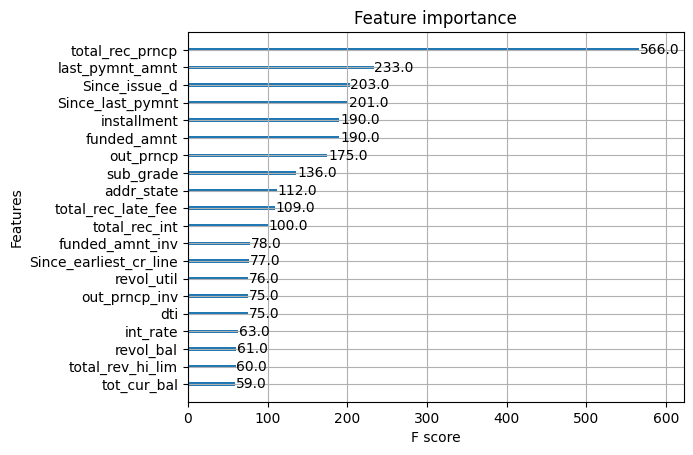

In [ ]:
# Plot feature importances
xgb.plot_importance(model, max_num_features=20)
plt.show()

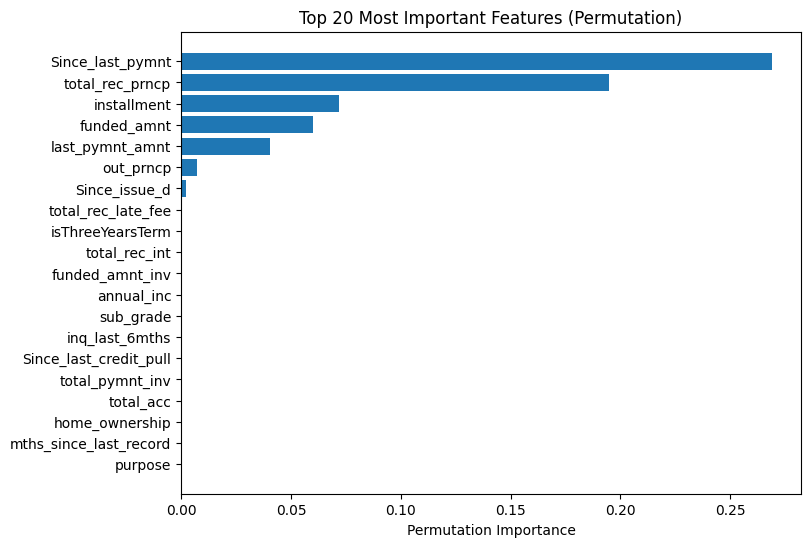

In [ ]:
from sklearn.inspection import permutation_importance

result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2)
top_features = 20
perm_sorted_idx = result.importances_mean.argsort()[-top_features:]

plt.figure(figsize=(8, 6))
plt.barh(X_test.columns[perm_sorted_idx], result.importances_mean[perm_sorted_idx])
plt.xlabel("Permutation Importance")
plt.title(f"Top {top_features} Most Important Features (Permutation)")
plt.show()

# Model Analysis

## PD and categorical features

In [72]:
U = X_test.copy()
U['PD'] = y_pred_prob
U['default'] = y_test

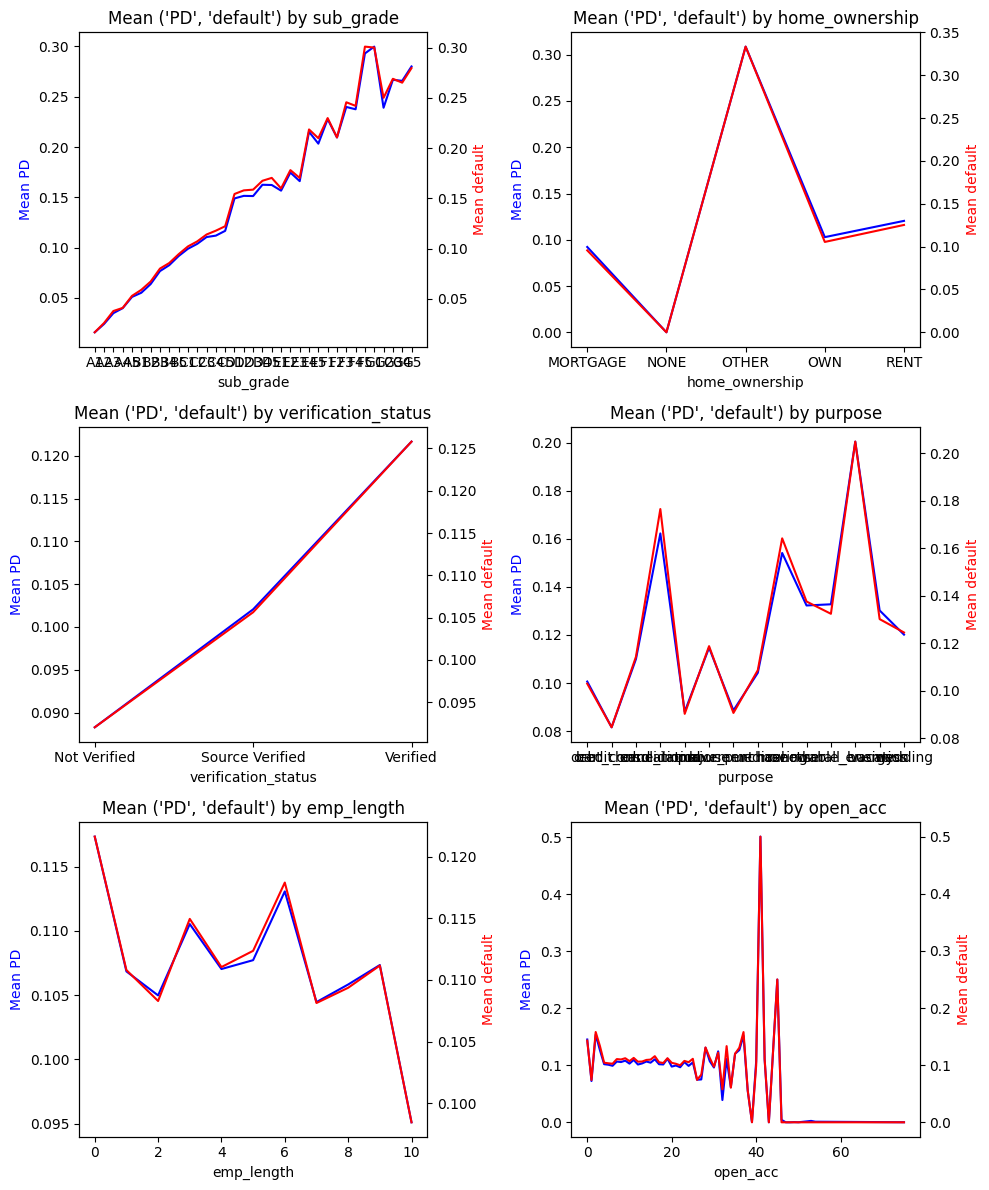

In [74]:
import matplotlib.pyplot as plt
import seaborn as sns
import math

def plot_PD_mean_by_category(df, features, target1, target2, n_cols=3):
    n_rows = math.ceil(len(features) / n_cols)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 4))
    axes = axes.flatten()

    for idx, col in enumerate(features):
        mean_target1 = df.groupby(col, observed=False)[target1].mean().reset_index()
        mean_target2 = df.groupby(col, observed=False)[target2].mean().reset_index()

        sns.lineplot(x=col, y=target1, data=mean_target1, ax=axes[idx], color='b')
        axes[idx].set_title(f'Mean {target1, target2} by {col}')
        axes[idx].set_xlabel(col)
        axes[idx].set_ylabel(f'Mean {target1}', color='b')

        ax2 = axes[idx].twinx()
        sns.lineplot(x=col, y=target2, data=mean_target2, ax=ax2, color='r')
        ax2.set_ylabel(f'Mean {target2}', color='r')

    for i in range(len(features), len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()


features = ['sub_grade', 'home_ownership', 'verification_status',
            'purpose', 'emp_length', 'open_acc']
plot_PD_mean_by_category(U, features, 'PD', 'default', n_cols=2)

## PD by state

<ipython-input-52-868884b6c4a6>:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  PD_by_state = X.groupby('addr_state')['PD'].mean()


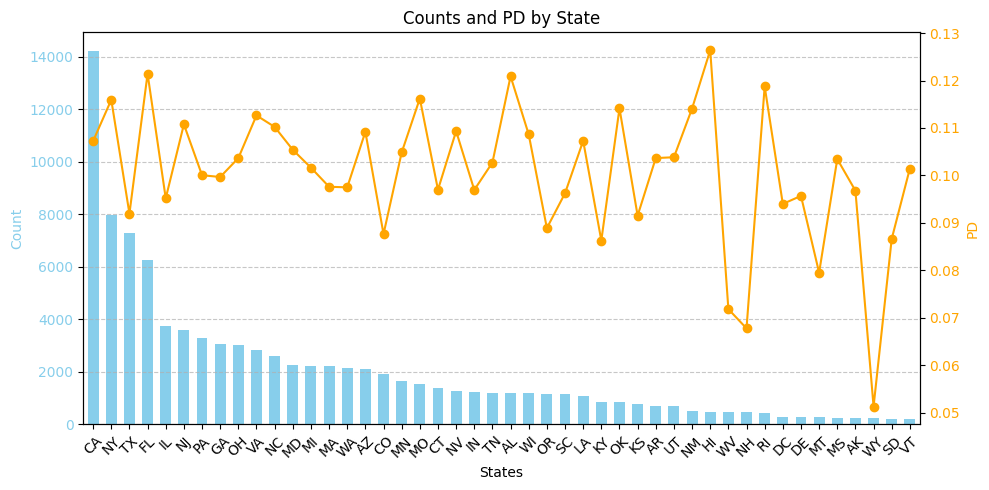

In [ ]:
PD_by_state = X.groupby('addr_state')['PD'].mean()
state_counts = X['addr_state'].value_counts()

fig, ax1 = plt.subplots(figsize=(10, 5))

state_counts.plot(kind='bar', ax=ax1, color='skyblue', width=0.6)
ax1.set_xlabel('States')
ax1.set_ylabel('Count', color='skyblue')
ax1.tick_params(axis='y', labelcolor='skyblue')
ax1.grid(axis='y', linestyle='--', alpha=0.7)
ax1.set_xticklabels(state_counts.index, rotation=45)

ax2 = ax1.twinx()
PD_by_state[state_counts.index].plot(kind='line', ax=ax2, color='orange', marker='o')
ax2.set_ylabel('PD', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

plt.title('Counts and PD by State')

plt.tight_layout()
plt.show()

## PD by purpose

<ipython-input-54-b4db68a2730e>:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  PD_by_purpose = X.groupby('purpose')['PD'].mean()


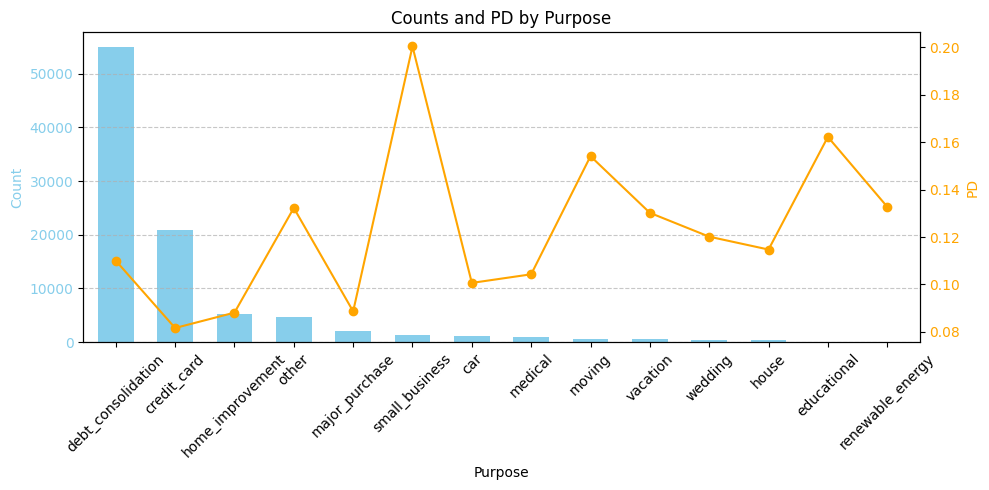

In [ ]:
PD_by_purpose = X.groupby('purpose')['PD'].mean()
purpose_counts = X['purpose'].value_counts()

fig, ax1 = plt.subplots(figsize=(10, 5))

purpose_counts.plot(kind='bar', ax=ax1, color='skyblue', width=0.6)
ax1.set_xlabel('Purpose')
ax1.set_ylabel('Count', color='skyblue')
ax1.tick_params(axis='y', labelcolor='skyblue')
ax1.grid(axis='y', linestyle='--', alpha=0.7)
ax1.set_xticklabels(purpose_counts.index, rotation=45)

ax2 = ax1.twinx()
PD_by_purpose[purpose_counts.index].plot(kind='line', ax=ax2, color='orange', marker='o')
ax2.set_ylabel('PD', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

plt.title('Counts and PD by Purpose')

plt.tight_layout()
plt.show()

## PD and numerical attributes

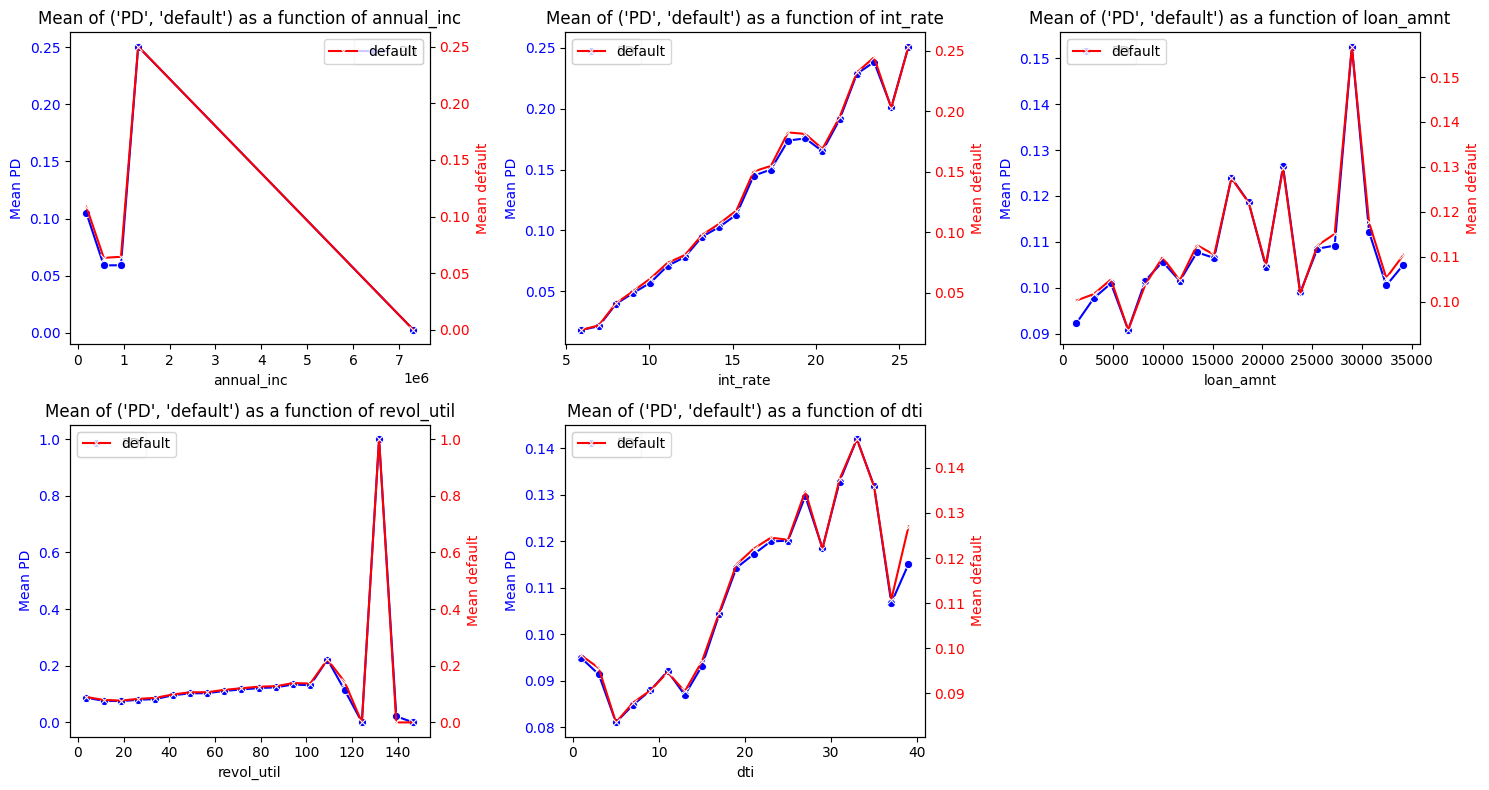

In [77]:
def plot_PD_by_continuous(df, features, target1, target2, n_cols=3, bins=20):
    n_rows = math.ceil(len(features) / n_cols)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 4))
    axes = axes.flatten()

    for idx, cont_col in enumerate(features):
        df_binned = df.copy()
        df_binned['binned'] = pd.cut(df_binned[cont_col], bins)

        mean_target1 = df_binned.groupby('binned', observed=False)[target1].mean().reset_index()
        mean_target2 = df_binned.groupby('binned', observed=False)[target2].mean().reset_index()
        bin_centers = mean_target1['binned'].apply(lambda x: x.mid)  # Get bin midpoints

        sns.lineplot(x=bin_centers, y=mean_target1[target1], ax=axes[idx], marker='o', color='b', label=target1)
        axes[idx].set_title(f'Mean of {target1, target2} as a function of {cont_col}')
        axes[idx].set_xlabel(cont_col)
        axes[idx].set_ylabel(f'Mean {target1}', color='b')
        axes[idx].tick_params(axis='y', labelcolor='b')

        ax2 = axes[idx].twinx()
        sns.lineplot(x=bin_centers, y=mean_target2[target2], ax=ax2, marker='x', color='r', label=target2)
        ax2.set_ylabel(f'Mean {target2}', color='r')
        ax2.tick_params(axis='y', labelcolor='r')

    for i in range(len(features), len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

features = ['annual_inc', 'int_rate', 'loan_amnt', 'revol_util', 'dti']
plot_PD_by_continuous(U, features, 'PD', 'default', n_cols=3, bins=20)

In [88]:
most_important = ['Since_last_pymnt', 'total_rec_prncp', 'installment', 'funded_amnt',
 'last_pymnt_amnt', 'out_prncp', 'Since_issue_d', 'default']

# most_important = ['total_rec_prncp', 'last_pymnt_amnt', 'Since_issue_d', 'Since_last_pymnt',
# 'installment', 'funded_amnt', 'out_prncp', 'sub_grade', 'addr_state', 'total_rec_late_fee',
# 'total_rec_int', 'funded_amnt_inv', 'Since_earliest_cr_line', 'revol_util', 'dti',
# 'out_prncp_inv', 'int_rate', 'revol_bal', 'total_rev_hi_lim', 'tot_cur_bal', 'default']

X = df[most_important].copy()

In [89]:
y = X['default']               # Target variable
X = X.drop('default', axis=1)  # Features


# Convert categorical columns to 'category' dtype
for col in X.select_dtypes('O').columns:
    X[col] = X[col].astype('category')

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# Create and train the XGBoost model with categorical handling
model = xgb.XGBClassifier(use_label_encoder=False,
            eval_metric='logloss',
            scale_pos_weight=(y_train.value_counts()[1] / y_train.value_counts()[0]),
            enable_categorical=True)

model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print(classification_report(y_test, y_pred))

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [04:20:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 1.00
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     83035
           1       1.00      0.96      0.98     10114

    accuracy                           1.00     93149
   macro avg       1.00      0.98      0.99     93149
weighted avg       1.00      1.00      1.00     93149



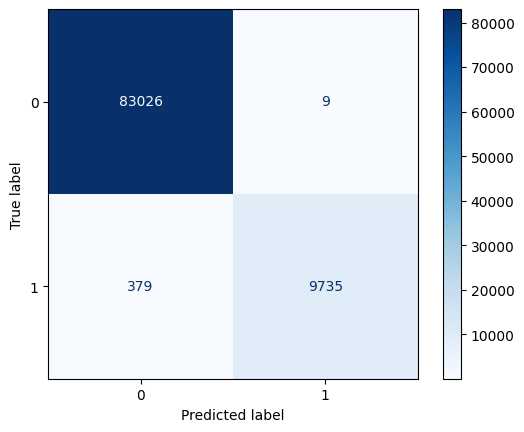

In [90]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap='Blues')
plt.show()